In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [3]:
path = 'drive/MyDrive/lfw/'

In [4]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


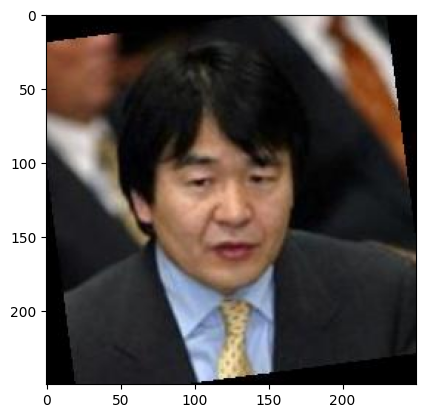

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [15]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Adjust the size of layers to handle 250*250*3 input
        self.fc1 = nn.Linear(250*250*3, 400)
        self.fc21 = nn.Linear(400, 20)  # For mean
        self.fc22 = nn.Linear(400, 20)  # For log-variance
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 250*250*3)

    def encoder(self, x):
        # Flatten the input and pass through the network
        h1 = F.relu(self.fc1(x.view(-1, 250*250*3)))
        return self.fc21(h1), self.fc22(h1)

    def decoder(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [16]:
import torch.nn.functional as F
# Check if CUDA (GPU support) is available and use it; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now proceed with the rest of your code
model = VAE().to(device)
x, _ = next(iter(dataloader))
x = x.to(device)
recon_batch, mu, logvar = model(x)
print("Shape of output from encoder:", mu.shape)

# Continue with your code...

Shape of output from encoder: torch.Size([32, 20])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 250*250*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [19]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [20]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass and optimize
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # Average loss for this epoch
    avg_loss = train_loss / len(dataloader.dataset)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

    # Troubleshooting if loss is not decreasing
    if epoch > 0 and avg_loss >= prev_loss:
        print("Loss is not decreasing, consider troubleshooting.")
        # Potential troubleshooting steps:
        # 1. Adjust learning rate
        # 2. Check for data preprocessing issues
        # 3. Experiment with different architectures
        # 4. Ensure proper initialization of model weights
        # 5. Look for bugs in the model definition and loss computation

    prev_loss = avg_loss

Epoch 1, Average Loss: 135339.7030
Epoch 2, Average Loss: 113514.4925
Epoch 3, Average Loss: 110050.1524
Epoch 4, Average Loss: 107145.4896
Epoch 5, Average Loss: 105442.5881
Epoch 6, Average Loss: 103938.7723
Epoch 7, Average Loss: 103059.1865
Epoch 8, Average Loss: 103932.3742
Loss is not decreasing, consider troubleshooting.
Epoch 9, Average Loss: 102445.7443
Epoch 10, Average Loss: 101474.8189


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

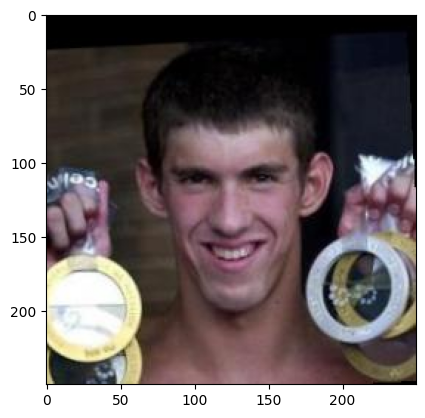

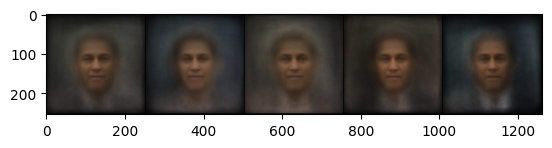

In [26]:
import matplotlib.pyplot as plt
import torch
import torchvision

# Function to display images
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Generate new samples
with torch.no_grad():
    # Sample random latent vectors from the normal distribution
    z = torch.randn(5, 20).to(device)
    # Decode the latent vectors
    sample = model.decoder(z).cpu()

# Reshape the generated images to match the input dimensions (3 channels, 250x250)
sample = sample.view(5, 3, 250, 250)

# Display the original image from the dataset
data, _ = next(iter(dataloader))
show_image(torchvision.utils.make_grid(data.cpu()[0]))

# Display the generated images
show_image(torchvision.utils.make_grid(sample))


